In [1]:
! pip install tifffile

In [1]:
import os
import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

In [2]:
train_path = "/kaggle/input/satelitedata/satalite data/data/images"
label_path = "/kaggle/input/satelitedata/satalite data/data/labels"

In [3]:
images = os.listdir(train_path)
print("Number of images = ", len(images))

Number of images =  306


In [4]:
images.sort(key = lambda images : int(images.split(".")[0]))

In [5]:
labels = os.listdir(label_path)
print("Number of labels = ", len(labels))

Number of labels =  456


In [6]:
modified_labels = [label for label in labels if "_" not in label.split(".")[0]]

In [7]:
print("Number of Modified labels = ",  len(modified_labels))

Number of Modified labels =  306


In [8]:
modified_labels.sort(key = lambda images : int(images.split(".")[0]))

In [9]:
def image_generator(img_path):
  if img_path.endswith(".tif"):
    yield tiff.imread(img_path)
  else:
    yield plt.imread(img_path)

In [10]:
arr_images = []
for indx in range(306):
    img_filename = f"{indx}.tif"
    img_path  = train_path + "/" + img_filename
    for img in image_generator(img_path):
        arr_images.append(img)

In [11]:
arr_labels = []
for indx in range(306):
    img_filename = f"{indx}.png"
    img_path  = label_path + "/" + img_filename
    for img in image_generator(img_path):
        arr_labels.append(img)


In [12]:
arr_images[5].shape, arr_labels[5].shape

((128, 128, 12), (128, 128))

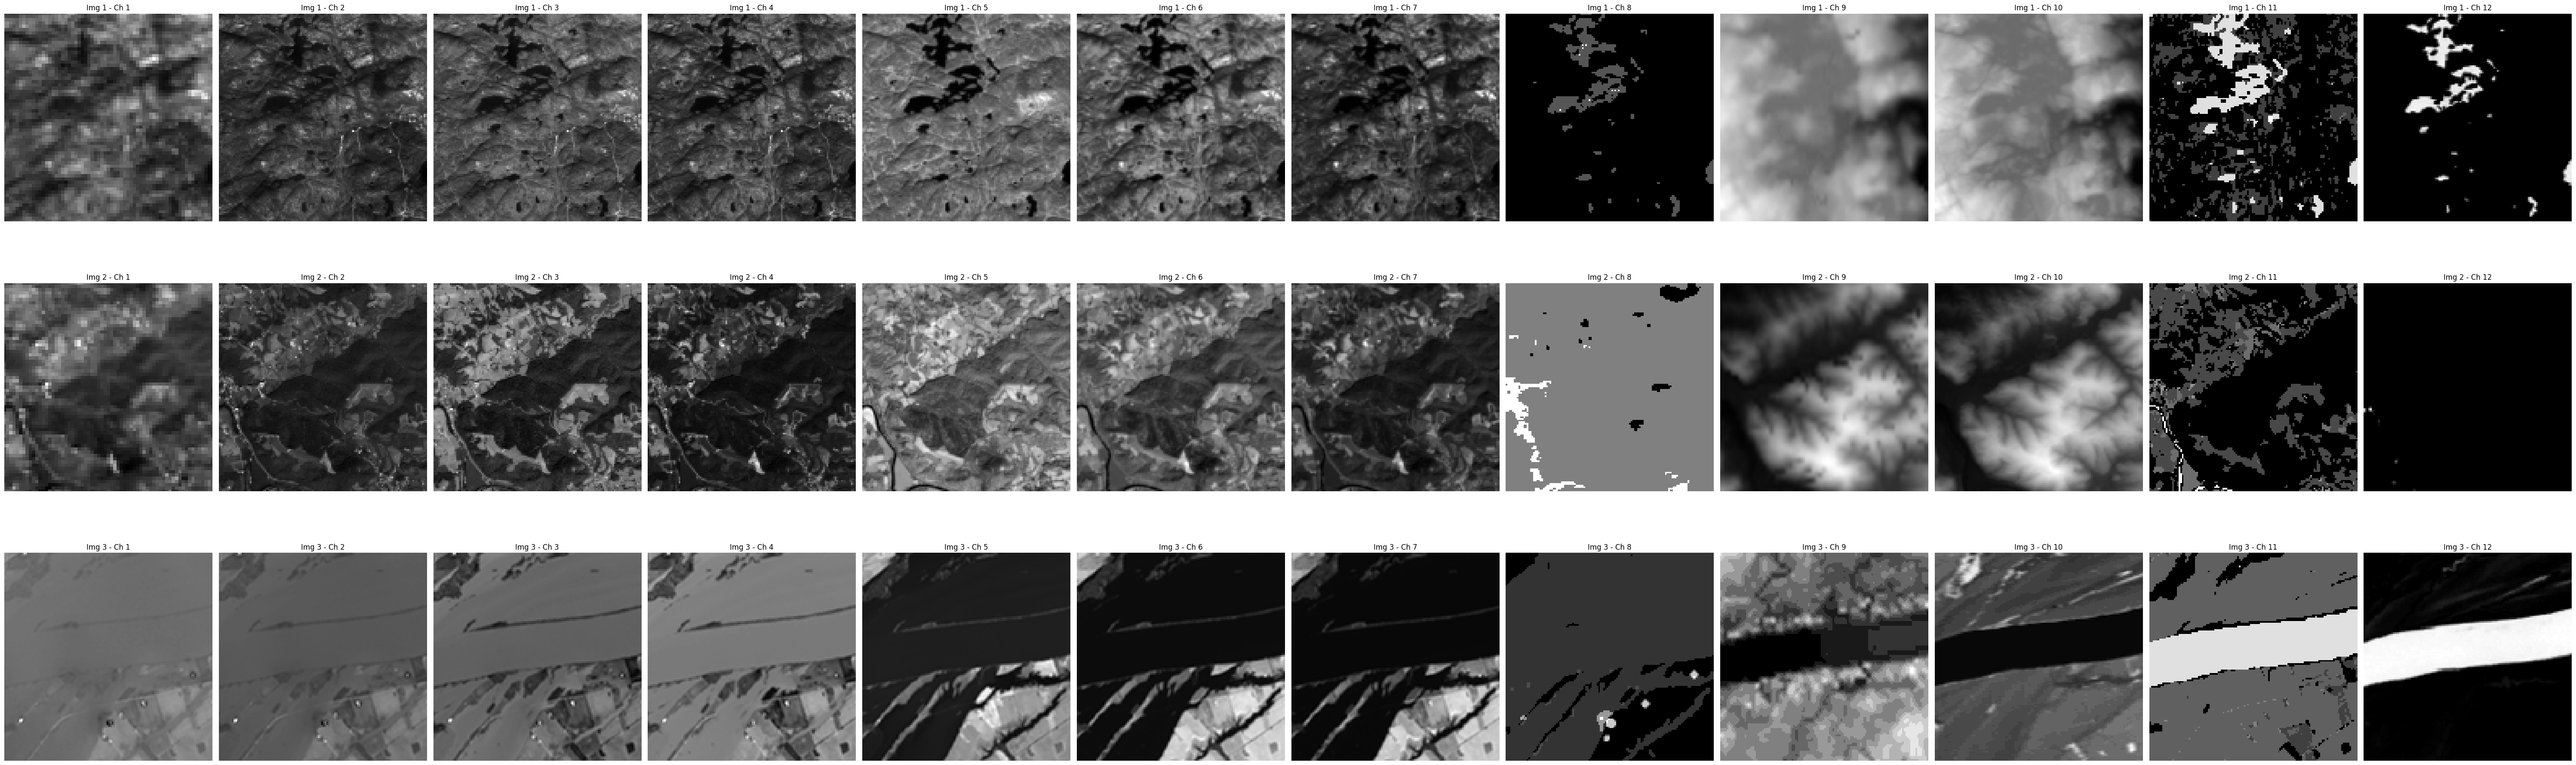

In [12]:
num_showed_img, num_channels = 3, 12

# Create a figure and axes with a grid layout
fig, axes = plt.subplots(nrows=num_showed_img, ncols=num_channels, figsize=(60, 20))

for img_idx in range(num_showed_img):
    for channel_idx in range(num_channels):
        ax = axes[img_idx, channel_idx]
        ax.imshow(arr_images[img_idx][:, :, channel_idx], cmap='gray')  # Show the channel of the image
        ax.set_title(f'Img {img_idx+1} - Ch {channel_idx+1}')
        ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


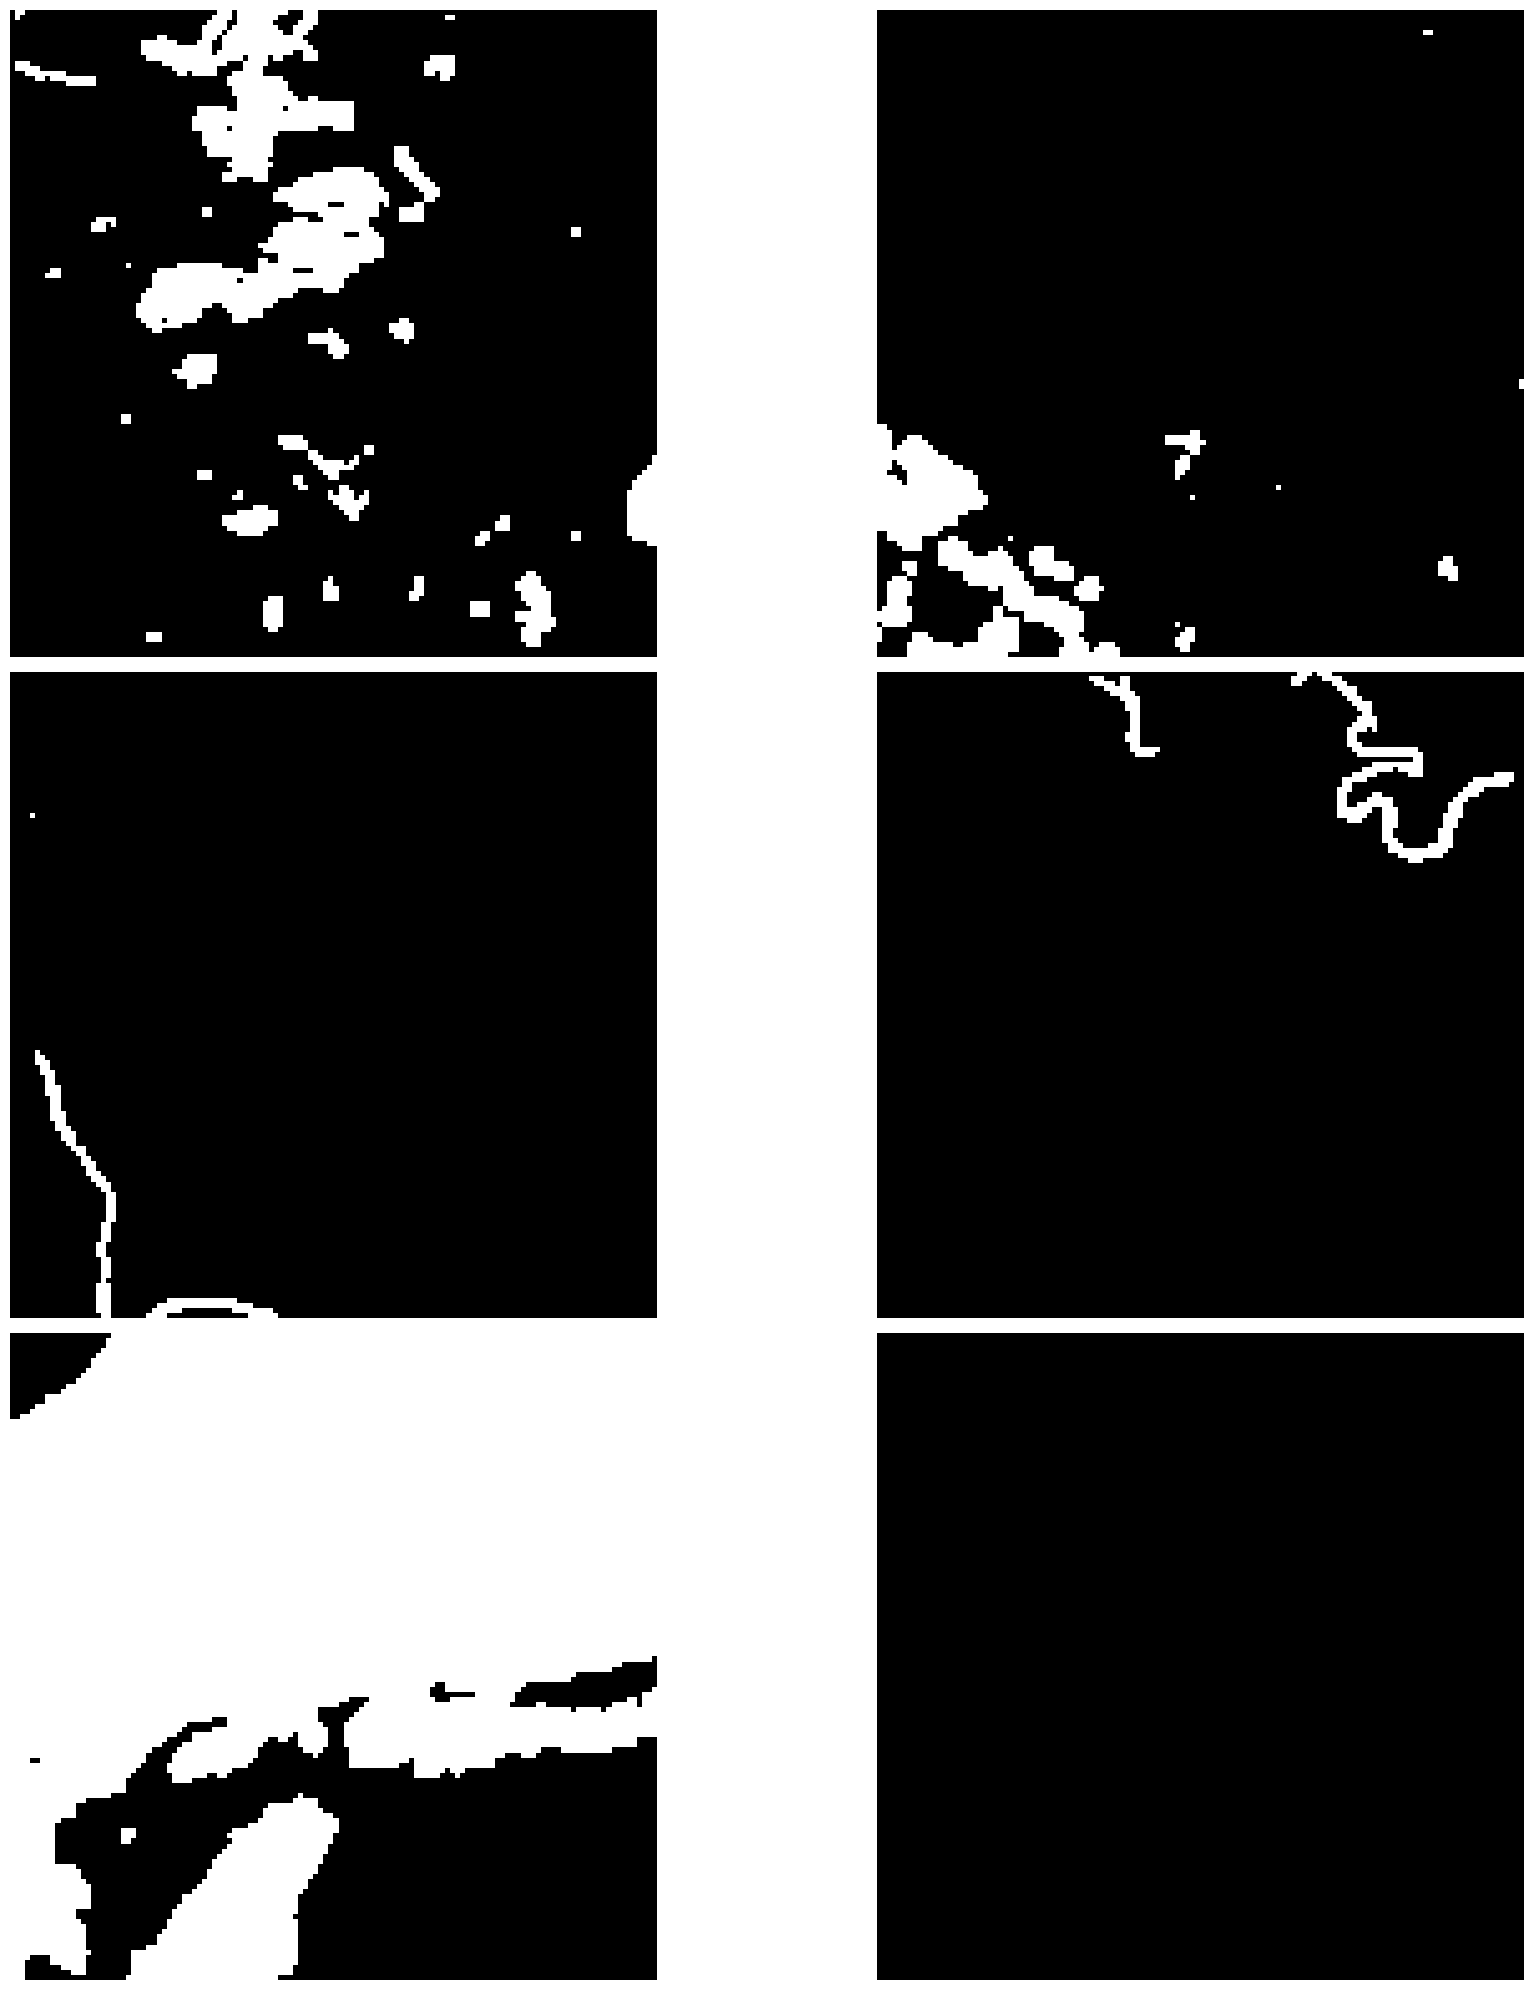

In [14]:
import matplotlib.pyplot as plt

num_showed_img = 6

# Create a figure and axes with a grid layout (3 rows, 2 columns)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))

for img_idx in range(num_showed_img):
    row = img_idx % 3  # Row index (0, 1, 2)
    col = img_idx // 3  # Column index (0, 1)

    ax = axes[row, col]
    ax.imshow(arr_labels[img_idx][:, :], cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()


# **Normalization**

In [12]:
normalized_arr = arr_images.copy()
masks = np.array(arr_labels)
normalized_arr = np.array(normalized_arr)


In [15]:
np.min(normalized_arr), np.max(normalized_arr)

(-9999, 15841)

In [12]:
import numpy as np

def add_wri_channel(images, green_band_index=1, red_band_index=2, nir_band_index=3, swir2_band_index=5):
    """
    Adds the WRI as a 13th channel to the satellite images.
    
    Args:
    - images: numpy array of shape (num_images, height, width, 12)
    - green_band_index: index of the green band in the image channels
    - red_band_index: index of the red band in the image channels
    - nir_band_index: index of the near-infrared band in the image channels
    - swir2_band_index: index of the SWIR2 band in the image channels
    
    Returns:
    - images_with_wri: numpy array with an additional WRI channel
    """
    # Extract the Green, Red, NIR, and SWIR2 bands
    green_band = images[:, :, :, green_band_index]
    red_band = images[:, :, :, red_band_index]
    nir_band = images[:, :, :, nir_band_index]
    swir2_band = images[:, :, :, swir2_band_index]

    # Compute WRI
    wri = (green_band + red_band) / (nir_band + swir2_band + 1e-10)  # Add epsilon to avoid division by zero

    # Expand WRI to match the dimensions of the images
    wri = np.expand_dims(wri, axis=-1)  # Shape: (num_images, height, width, 1)

    # Append WRI as the 13th channel
    images_with_wri = np.concatenate((images, wri), axis=-1)  # Shape: (num_images, height, width, 13)

    return images_with_wri

# Assuming your satellite images are stored in a variable called 'satellite_images' (shape: num_images, height, width, 12)
normalized_arr = add_wri_channel(normalized_arr)


In [15]:
x_train, x_val, y_train, y_val = train_test_split(normalized_arr, masks, test_size=0.15, random_state=42)

In [16]:
x_train_normalized = x_train.copy()
x_val_normalized = x_val.copy()

In [19]:
def normalization(img):
    for c in range(12):
        min_val = np.min(img[:, :, c])
        max_val = np.max(img[:, :, c]) 
        if max_val > min_val:
            img[:, :, c] = (img[:, :, c] - min_val) / (max_val - min_val)  
        else:
            img[:, :, c] = 0  
 


In [20]:
for i,img in enumerate(x_train_normalized):
 normalization(x_train_normalized[i])

In [21]:
for i,img in enumerate(x_val_normalized):
   normalization(x_val_normalized[i])

In [17]:
x_train_normalized, x_val_normalized = x_train_normalized / 65555, x_val_normalized / 65555

In [18]:
np.min(x_train_normalized), np.max(x_train_normalized)

(-0.1525284112577225, 0.2416444207154298)

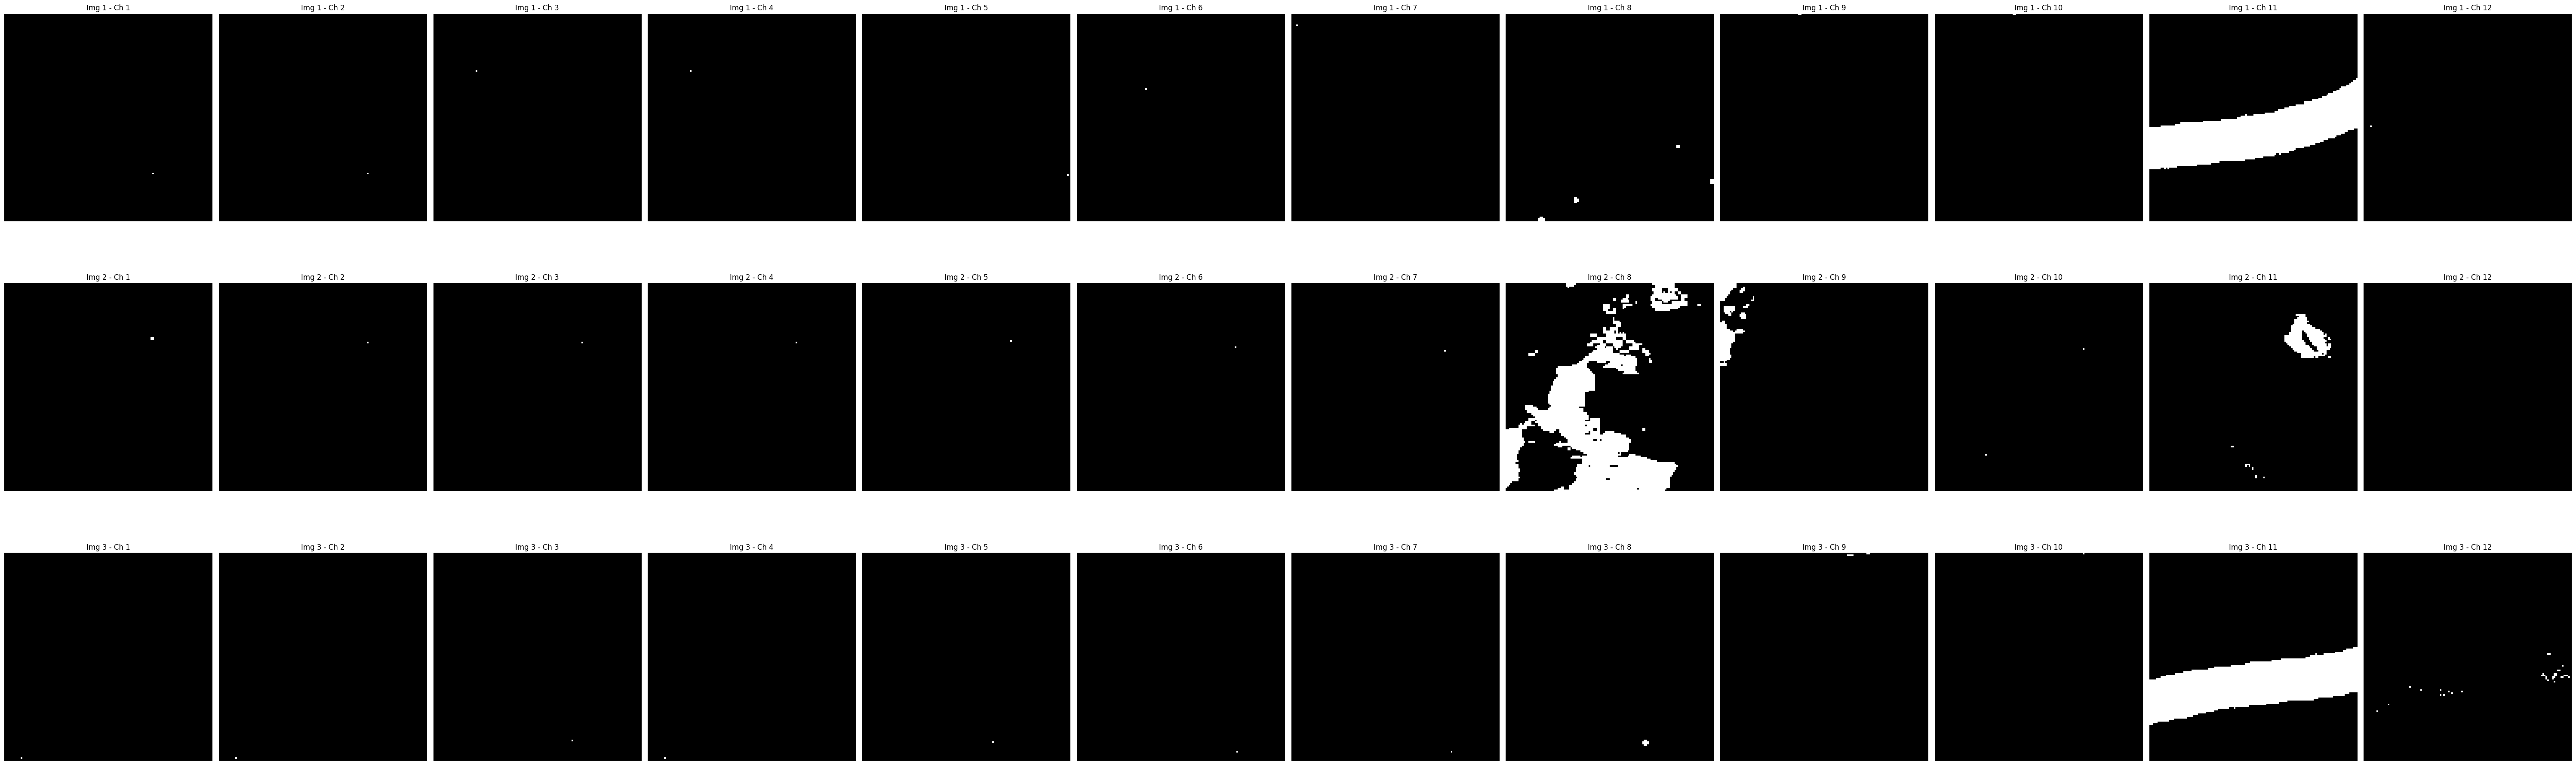

In [75]:
num_showed_img, num_channels = 3, 12

# Create a figure and axes with a grid layout
fig, axes = plt.subplots(nrows=num_showed_img, ncols=num_channels, figsize=(60, 20))

for img_idx in range(num_showed_img):
    for channel_idx in range(num_channels):
        ax = axes[img_idx, channel_idx]
        ax.imshow(x_train_normalized[img_idx][:, :, channel_idx], cmap='gray')  # Show the channel of the image
        ax.set_title(f'Img {img_idx+1} - Ch {channel_idx+1}')
        ax.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()


# **Model**

In [14]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, UpSampling2D, Concatenate, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from sklearn.metrics import f1_score
import numpy as np
from tensorflow.keras.layers import UpSampling2D, Conv2D, concatenate
from tensorflow.keras import backend as K


In [19]:
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
y_val = y_val.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], 1))


In [20]:
import numpy as np
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=40, p=0.5),
    A.RandomBrightnessContrast(p=0.2)
])

x_train_normalized = x_train_normalized.astype(np.float32)
y_train = y_train.astype(np.float32)

# Initialize lists to collect augmented images and masks
aug_train, aug_masks = [], []

for image, mask in zip(x_train_normalized, y_train):
    # Apply the same augmentations to both the image and the mask
    augmented = transform(image=image, mask=mask)
    augmented_image = augmented['image']  # No need to convert to numpy array
    augmented_mask = augmented['mask']  # No need to convert to numpy array

    # Append the augmented images and masks to the lists
    aug_train.append(augmented_image)
    aug_masks.append(augmented_mask)

# Convert lists to numpy arrays
aug_train = np.array(aug_train)
aug_masks = np.array(aug_masks)

# Check shapes
print("Shape of x_train_normalized:", x_train_normalized.shape)
print("Shape of aug_train:", aug_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of aug_masks:", aug_masks.shape)

# Concatenate the augmented data with the original data
x_train_augmented = np.concatenate((x_train_normalized, aug_train), axis=0)
y_train_augmented = np.concatenate((y_train, aug_masks), axis=0)

print(f"Augmented images shape: {x_train_augmented.shape}")
print(f"Augmented masks shape: {y_train_augmented.shape}")


/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.15 (you have 1.4.14). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Shape of x_train_normalized: (260, 128, 128, 12)
Shape of aug_train: (260, 128, 128, 12)
Shape of y_train: (260, 128, 128, 1)
Shape of aug_masks: (260, 128, 128, 1)
Augmented images shape: (520, 128, 128, 12)
Augmented masks shape: (520, 128, 128, 1)


In [21]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [22]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    # Flatten the tensors
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    # Compute intersection and union
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f)
    
    # Compute Dice coefficient
    dice_coeff = (2. * intersection + smooth) / (union + smooth)
    
    # Compute Dice loss
    return 1. - dice_coeff




In [30]:
# Define the number of filters for each layer
neuronsL1 = 32
neuronBottom = 64

# Input layer
input_size = (128, 128, 12)
inputs = Input(input_size)

# Apply BatchNormalization directly after the input layer
norm_inputs = BatchNormalization()(inputs)

# Contracting Path (encoder part)
conv1 = Conv2D(neuronsL1, (3, 3), activation='relu', padding='same')(norm_inputs)
conv1 = Conv2D(neuronsL1, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

# Bottleneck
conv3 = Conv2D(neuronBottom, (3, 3), activation='relu', padding='same')(pool1)
conv3 = Conv2D(neuronBottom, (3, 3), activation='relu', padding='same')(conv3)
conv3 = Dropout(0.15)(conv3)
conv3 = BatchNormalization()(conv3)

# Expanding Path (decoder part)
up1 = UpSampling2D(size=(2, 2))(conv3)
up1 = concatenate([up1, conv1], axis=3)
conv4 = Conv2D(neuronsL1, (3, 3), activation='relu', padding='same')(up1)
conv4 = Conv2D(neuronsL1, (3, 3), activation='relu', padding='same')(conv4)

# Output layer
outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv4)

# Define the model
model = Model(inputs=[inputs], outputs=[outputs])

# Compile the model
model.compile(optimizer=SGD(learning_rate=0.0007), loss= "binary_crossentropy", metrics=['accuracy'])

# Print model summary
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │         48 │ input_layer_2[0]… │
│ (BatchNormalizatio… │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │      3,488 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_14[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_15[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_16[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_17[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ dropout_2[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 128, 128,  │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 96)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │     27,680 │ concatenate_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_18[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │         33 │ conv2d_19[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 105,553 (412.32 KB)

 Trainable params: 105,337 (411.47 KB)

 Non-trainable params: 216 (864.00 B)

In [82]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(x_train) // batch_size,
    validation_data=val_generator,
    validation_steps=len(x_val) // batch_size,
    epochs=100,
    callbacks=[early_stopping]
)

/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:619: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (275, 128, 128, 12) (12 channels).
  warnings.warn(


Epoch 1/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.5888 - loss: 0.9950

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 136ms/step - accuracy: 0.5916 - loss: 0.9949 - val_accuracy: 0.6843 - val_loss: 0.9938
Epoch 2/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - accuracy: 0.7380 - loss: 0.9892 - val_accuracy: 0.6039 - val_loss: 0.9944
Epoch 3/100
 4/34 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8198 - loss: 0.9854

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.7513 - loss: 0.9902 - val_accuracy: 0.7023 - val_loss: 0.9934
Epoch 4/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7543 - loss: 0.9893 - val_accuracy: 0.5421 - val_loss: 0.9952
Epoch 5/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - accuracy: 0.6878 - loss: 0.9908 - val_accuracy: 0.6818 - val_loss: 0.9939
Epoch 6/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - accuracy: 0.7683 - loss: 0.9829 - val_accuracy: 0.6123 - val_loss: 0.9943
Epoch 7/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7265 - loss: 0.9907 - val_accuracy: 0.6340 - val_loss: 0.9946
Epoch 8/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.7152 - loss: 0.9911 - val_accuracy: 0.7762 - val_loss: 0.9902
Epoch 9/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7418 - loss: 0.9781 - val_accuracy: 0.7236 - val_loss: 0.9927
Epoch 10/100
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - accuracy: 0.7380 - loss: 0.9902 - val_accuracy: 0.469

In [31]:
# Step2 : train the model from initial weights
history = model.fit(
    x_train_augmented,
    y_train_augmented,
    validation_data=(x_val_normalized, y_val),
    epochs=200,  # Maximum epochs
    batch_size=16,
    callbacks=[early_stopping]  # Apply early stopping
)


Epoch 1/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 12s 195ms/step - accuracy: 0.3163 - loss: 0.7585 - val_accuracy: 0.6573 - val_loss: 0.6856
Epoch 2/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5817 - loss: 0.5937 - val_accuracy: 0.6664 - val_loss: 0.6594
Epoch 3/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6899 - loss: 0.4967 - val_accuracy: 0.6664 - val_loss: 0.6170
Epoch 4/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7309 - loss: 0.4134 - val_accuracy: 0.6664 - val_loss: 0.5607
Epoch 5/200
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7619 - loss: 0.3348 - val_accuracy: 0.6664 - val_loss: 0.4974


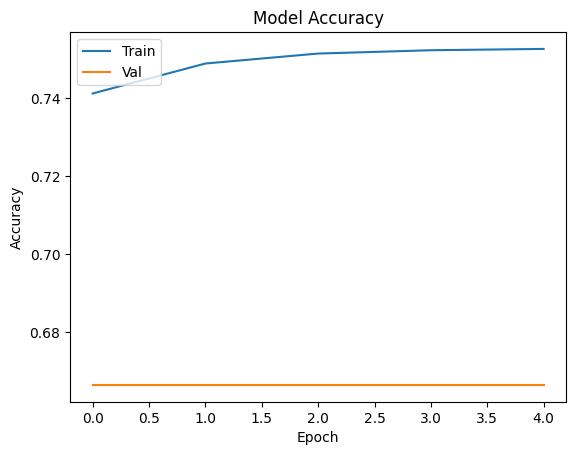

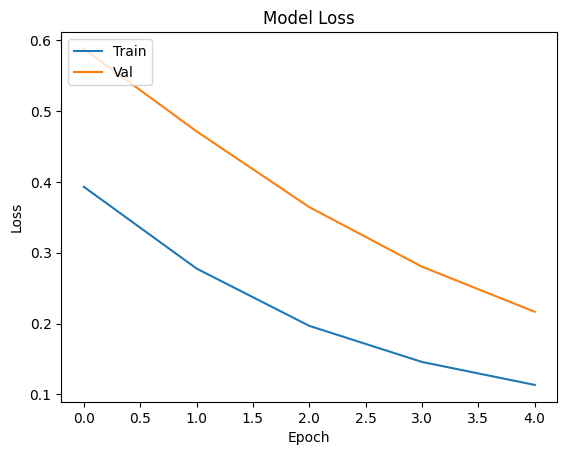

In [37]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


# **Pre-trained Models**

In [26]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model


In [27]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Conv2D, UpSampling2D, BatchNormalization, ReLU, Input
from tensorflow.keras.models import Model

def build_custom_resnet50_with_bn(input_shape=(128, 128, 12), num_classes=1):
    inputs = Input(shape=input_shape)

    # Initial Conv and Batch Normalization
    x = BatchNormalization()(inputs)

    # Load the pre-trained ResNet50 model without the top layer
    base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(None, None, 3))
    x_custom_input = Conv2D(3, (1, 1), padding='same')(x)  # Convert 13 channels to 3 channels
    x = base_model(x_custom_input)

    # Decoder layers to upsample to original input shape
    x = UpSampling2D((2, 2))(x)  # Scale factor 2
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)  # Scale factor 2
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)  # Scale factor 2
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = UpSampling2D((2, 2))(x)  # Scale factor 2
    x = UpSampling2D((2, 2))(x)  # Additional upsampling to match original input size

    # Final output layer to match target shape
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)  # Ensure num_classes is 1 for binary classification

    model = Model(inputs=inputs, outputs=outputs)

    return model

# Instantiate and compile the model
model = build_custom_resnet50_with_bn(input_shape=(128, 128, 12), num_classes=1)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print shapes for debugging
print(f"Model output shape: {model.output_shape}")

# Train the model
history = model.fit(
    x_train_augmented,
    y_train_augmented,
    validation_data=(x_val_normalized, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stopping]
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model output shape: (None, 128, 128, 1)
Epoch 1/100


I0000 00:00:1726860546.108162     114 service.cc:145] XLA service 0x7acff4004370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726860546.108246     114 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/33 ━━━━━━━━━━━━━━━━━━━━ 34:39 65s/step - accuracy: 0.3731 - loss: 0.7843

I0000 00:00:1726860571.660939     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.7075 - loss: 0.1341

I0000 00:00:1726860595.962742     115 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_25', 16 bytes spill stores, 16 bytes spill loads



33/33 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.7085 - loss: 0.1317 - val_accuracy: 0.6664 - val_loss: 0.0421
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 79ms/step - accuracy: 0.7490 - loss: 0.0095 - val_accuracy: 0.6664 - val_loss: 0.0417
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - accuracy: 0.7423 - loss: 0.0091 - val_accuracy: 0.6664 - val_loss: 0.0155
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7703 - loss: 0.0073 - val_accuracy: 0.6664 - val_loss: 0.0112
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7480 - loss: 0.0078 - val_accuracy: 0.6664 - val_loss: 0.0103
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7383 - loss: 0.0077 - val_accuracy: 0.6664 - val_loss: 0.0102
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7529 - loss: 0.0073 - val_accuracy: 0.6664 - val_loss: 0.0113
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - accuracy: 0.7551 - loss: 0.0072 - val_accuracy: 0.6664 - val_lo

In [37]:
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 128, 128, 13)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 128, 128, 3)    │            42 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_26 (UpSampling2D) │ (None, 8, 8, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 8, 8, 256)      │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_27 (UpSampling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 16, 16, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_28 (UpSampling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_29 (UpSampling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_30 (UpSampling2D) │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 128, 128, 1)    │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 85,920,259 (327.76 MB)

 Trainable params: 28,622,379 (109.19 MB)

 Non-trainable params: 53,120 (207.50 KB)

 Optimizer params: 57,244,760 (218.37 MB)

In [45]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import VGG19

# Function to build the encoder
def build_encoder(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Reduce channel dimension to 3
    x = layers.Conv2D(3, (3, 3), padding='same')(inputs)

    # Load VGG19 without the top (fully connected) layers
    vgg19 = VGG19(include_top=False, weights='imagenet', input_shape=(input_shape[0], input_shape[1], 3))

    # Encoder layers
    s1 = vgg19.get_layer('block1_conv2').output  # 128x128x64
    s2 = vgg19.get_layer('block2_conv2').output  # 64x64x128
    s3 = vgg19.get_layer('block3_conv4').output  # 32x32x256
    s4 = vgg19.get_layer('block4_conv4').output  # 16x16x512

    # Bridge
    b = vgg19.get_layer('block5_conv4').output  # 8x8x512

    # Create a new model with the reduced input and VGG19 layers
    encoder_model = Model(inputs=vgg19.input, outputs=[s1, s2, s3, s4, b])

    # Get the outputs of the encoder model
    s1, s2, s3, s4, b = encoder_model(x)

    return inputs, (s1, s2, s3, s4), b

# Function to build the decoder
def build_decoder(skip_connections, bridge):
    # Decoder layers
    s1, s2, s3, s4 = skip_connections

    d1 = decoder_block(bridge, s4, 512)  # 16x16x512
    d2 = decoder_block(d1, s3, 256)  # 32x32x256
    d3 = decoder_block(d2, s2, 128)  # 64x64x128
    d4 = decoder_block(d3, s1, 64)  # 128x128x64

    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)  # 128x128x1

    return outputs

# Function to build a decoder block
def decoder_block(inputs, skip, filters):
    x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(inputs)
    x = layers.concatenate([x, skip])
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

# Input shape
input_shape = (128, 128, 12)

# Build the encoder
inputs, skip_connections, bridge = build_encoder(input_shape)

# Build the decoder
outputs = build_decoder(skip_connections, bridge)

# Build the model
model = Model(inputs, outputs)
model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Assume you have X_train and y_train as your training data and labels
# model.fit(X_train, y_train, epochs=10, batch_size=16)


Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_65 (Conv2D)  │ (None, 128, 128,  │        327 │ input_layer_15[0… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_23       │ [(None, 128, 128, │ 20,024,384 │ conv2d_65[0][0]   │
│ (Functional)        │ 64), (None, 64,   │            │                   │
│                     │ 64, 128), (None,  │            │                   │
│                     │ 32, 32, 256),     │            │                   │
│                     │ (None, 16, 16,    │            │                   │
│                     │ 512), (None, 8,   │            │                   │
│                     │ 8, 512)]          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 16, 16,    │  1,049,088 │ functional_23[0]… │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 16, 16,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 1024)             │            │ functional_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_66 (Conv2D)  │ (None, 16, 16,    │  4,719,104 │ concatenate_9[0]… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_66[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_67 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ activation_8[0][… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      2,048 │ conv2d_67[0][0]   │
│ (BatchNormalizatio… │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_9        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│ (Activation)        │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_5  │ (None, 32, 32,    │    524,544 │ activation_9[0][… │
│ (Conv2DTranspose)   │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_10      │ (None, 32, 32,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 512)              │            │ functional_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_68 (Conv2D)  │ (None, 32, 32,    │  1,179,904 │ concatenate_10[0… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_68[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                 

 Total params: 31,172,360 (118.91 MB)

 Trainable params: 31,168,520 (118.90 MB)

 Non-trainable params: 3,840 (15.00 KB)

In [46]:
# Step 6: Train the Model (assuming you have preprocessed data)
# x_train, y_train, x_val, y_val = your_preprocessed_data
# Train the model
history = model.fit(
    x_train_augmented,  # Training images
    y_train_augmented,  # Training masks
    validation_data=(x_val_normalized, y_val),  # Validation data
    epochs=100,  # Number of epochs
    batch_size=16,  # Batch size
    callbacks=[early_stopping]  # Early stopping
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 41s 582ms/step - accuracy: 0.6814 - loss: 0.3436 - val_accuracy: 0.6664 - val_loss: 0.0499
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7493 - loss: 0.0722 - val_accuracy: 0.6643 - val_loss: 0.0825
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.7695 - loss: 0.0381 - val_accuracy: 0.6664 - val_loss: 0.0176
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7634 - loss: 0.0249 - val_accuracy: 0.6664 - val_loss: 0.0822
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.7580 - loss: 0.0198 - val_accuracy: 0.6664 - val_loss: 0.0629


In [23]:
! pip install segmentation_models_pytorch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 51.5 MB/s eta 0:00:0000:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=c29997e04a7d24305799e564630f797198184efaead6af59d599347a1966f5e7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=fb8b3e15c69b43977299a5852f2846f3a068fd73c46856ca20628d425fb75afd
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-py

In [ ]:
# (None, 64, 64, 64)
# (None, 32, 32, 256)
# (None, 16, 16, 512)
# (None, 8, 8, 1024)

In [24]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import segmentation_models_pytorch as smp


In [25]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm

# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train_augmented).permute(0, 3, 1, 2).float()  # Convert to (batch, channels, height, width)
y_train_tensor = torch.tensor(y_train_augmented).permute(0, 3, 1, 2).float()

x_val_tensor = torch.tensor(x_val_normalized).permute(0, 3, 1, 2).float()
y_val_tensor = torch.tensor(y_val).permute(0, 3, 1, 2).float()

# Create datasets and data loaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=16)

In [26]:
def train_model( model, best_val_loss,  num_epochs = 30):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        train_acc = 0.0
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for x_batch, y_batch in train_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * x_batch.size(0)
            train_acc += calculate_accuracy(outputs, y_batch) * x_batch.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_acc /= len(train_loader.dataset)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_acc = 0.0
        with torch.no_grad():
            for x_val_batch, y_val_batch in valid_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                val_outputs = model(x_val_batch)
                val_loss += criterion(val_outputs, y_val_batch).item() * x_val_batch.size(0)
                val_acc += calculate_accuracy(val_outputs, y_val_batch) * x_val_batch.size(0)

        val_loss /= len(valid_loader.dataset)
        val_acc /= len(valid_loader.dataset)

        print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Train Accuracy = {train_acc:.4f}, Val Loss = {val_loss:.4f}, Val Accuracy = {val_acc:.4f}")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), "best_model.pth")  # Save the best model
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= early_stopping_patience:
            print("Early stopping triggered")
            break

In [27]:
def calculate_accuracy(pred, target, threshold=0.5):
    """
    Calculate accuracy between the predicted mask and the target mask.
    
    Args:
        pred (torch.Tensor): The predicted mask from the model, usually of shape (batch_size, 1, height, width).
        target (torch.Tensor): The ground truth mask, same shape as pred.
        threshold (float): Threshold to convert the predicted mask to binary (0 or 1).
        
    Returns:
        float: The accuracy as the percentage of correctly predicted pixels.
    """
    # Apply threshold to get binary predictions (0 or 1)
    pred = (pred > threshold).float()
    
    # Calculate the number of correct predictions (True Positives + True Negatives)
    correct = (pred == target).float().sum()
    
    # Total number of pixels
    total = torch.numel(pred)
    
    # Accuracy is the ratio of correct predictions to total pixels
    accuracy = correct / total
    return accuracy.item()

In [28]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import segmentation_models_pytorch as smp
from tqdm import tqdm



# Define model, criterion, and optimizer
model_Unet = smp.Unet(
    encoder_name="resnet50",  
    encoder_weights="imagenet", 
    in_channels=12, 
    classes=1
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_Unet.parameters(), lr=0.0005)

# Early stopping criteria
early_stopping_patience = 5
best_val_loss = float("inf")
epochs_without_improvement = 0

# Training loop
train_model(model_Unet, best_val_loss)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 338MB/s]


Epoch 1: Train Loss = 0.5049, Train Accuracy = 0.7233, Val Loss = 0.2918, Val Accuracy = 0.6664


Epoch 2: Train Loss = 0.1945, Train Accuracy = 0.7523, Val Loss = 0.1361, Val Accuracy = 0.6664


Epoch 3: Train Loss = 0.1072, Train Accuracy = 0.7525, Val Loss = 0.0889, Val Accuracy = 0.6664


Epoch 4: Train Loss = 0.0682, Train Accuracy = 0.7525, Val Loss = 0.0625, Val Accuracy = 0.6657


Epoch 5: Train Loss = 0.0474, Train Accuracy = 0.7526, Val Loss = 0.0425, Val Accuracy = 0.6664


Epoch 6: Train Loss = 0.0357, Train Accuracy = 0.7526, Val Loss = 0.0333, Val Accuracy = 0.6664


Epoch 7: Train Loss = 0.0283, Train Accuracy = 0.7526, Val Loss = 0.0272, Val Accuracy = 0.6664


Epoch 8: Train Loss = 0.0233, Train Accuracy = 0.7526, Val Loss = 0.0246, Val Accuracy = 0.6661


Epoch 9: Train Loss = 0.0198, Train Accuracy = 0.7526, Val Loss = 0.0205, Val Accuracy = 0.6664


Epoch 10: Train Loss = 0.0172, Train Accuracy = 0.7526, Val Loss = 0.0177, Val Accuracy = 0.6664


Epoch 11: Train Loss = 0.0153, Train Accuracy = 0.7526, Val Loss = 0.0162, Val Accuracy = 0.6664


Epoch 12: Train Loss = 0.0138, Train Accuracy = 0.7526, Val Loss = 0.0150, Val Accuracy = 0.6664


Epoch 13: Train Loss = 0.0127, Train Accuracy = 0.7526, Val Loss = 0.0139, Val Accuracy = 0.6664


Epoch 14: Train Loss = 0.0118, Train Accuracy = 0.7526, Val Loss = 0.0132, Val Accuracy = 0.6664


Epoch 15: Train Loss = 0.0111, Train Accuracy = 0.7526, Val Loss = 0.0126, Val Accuracy = 0.6664


Epoch 16: Train Loss = 0.0106, Train Accuracy = 0.7526, Val Loss = 0.0121, Val Accuracy = 0.6664


Epoch 17: Train Loss = 0.0101, Train Accuracy = 0.7526, Val Loss = 0.0117, Val Accuracy = 0.6664


Epoch 18: Train Loss = 0.0097, Train Accuracy = 0.7526, Val Loss = 0.0114, Val Accuracy = 0.6664


Epoch 19: Train Loss = 0.0094, Train Accuracy = 0.7526, Val Loss = 0.0111, Val Accuracy = 0.6664


Epoch 20: Train Loss = 0.0091, Train Accuracy = 0.7526, Val Loss = 0.0108, Val Accuracy = 0.6664


Epoch 21: Train Loss = 0.0089, Train Accuracy = 0.7526, Val Loss = 0.0137, Val Accuracy = 0.6661


Epoch 22: Train Loss = 0.0087, Train Accuracy = 0.7526, Val Loss = 0.0113, Val Accuracy = 0.6662


Epoch 23: Train Loss = 0.0085, Train Accuracy = 0.7526, Val Loss = 0.0111, Val Accuracy = 0.6663


Epoch 24: Train Loss = 0.0084, Train Accuracy = 0.7526, Val Loss = 0.0123, Val Accuracy = 0.6661


Epoch 25: Train Loss = 0.0082, Train Accuracy = 0.7526, Val Loss = 0.0168, Val Accuracy = 0.6660
Early stopping triggered


In [ ]:
# After training the model
torch.save(model_Unet, 'Unet_res.pth')


In [ ]:
# Load the entire model
Unet_res = torch.load('/kaggle/working/Unet_res.pth')

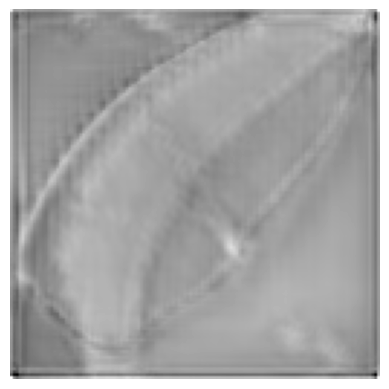

In [39]:
# prediction
input_img = x_val_normalized[19].astype(np.float32)
input_img.shape = (1, 128, 128, 12)
normalization(input_img)
input_img = np.transpose(input_img, (0, 3, 1, 2)) 
input_img = torch.from_numpy(input_img)
input_img = input_img.to('cuda' if torch.cuda.is_available() else 'cpu')
# Get predictions
with torch.no_grad(): 
    prediction = Unet_res(input_img)
prediction = np.squeeze(prediction, axis = 0)
prediction = np.transpose(prediction.cpu().detach().numpy(), (1, 2, 0))
plt.imshow(prediction, cmap='gray')  
plt.axis('off')  # Hide the axes
plt.show()

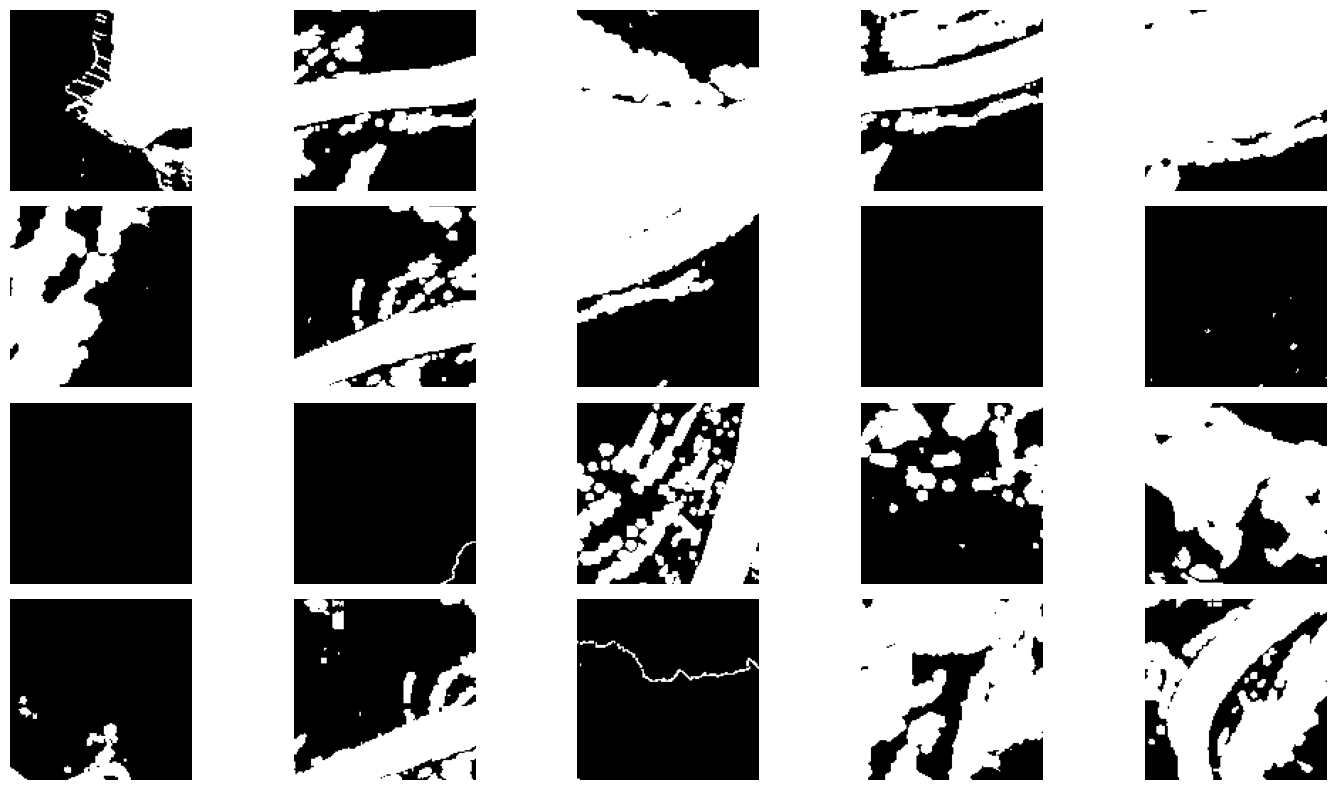

In [51]:
import matplotlib.pyplot as plt

# Function to plot multiple masks in a grid
def plot_multiple_masks(y_val, num_masks=20):
    # Determine grid size for displaying 20 images (e.g., 4 rows x 5 columns)
    num_cols = 5
    num_rows = num_masks // num_cols + (num_masks % num_cols > 0)
    
    # Create a figure for subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8))
    
    for i in range(num_masks):
        row = i // num_cols
        col = i % num_cols
        
        # Select the mask and remove the extra dimension
        mask = y_val[i].squeeze()
        
        # Plot the mask in the grid
        axes[row, col].imshow(mask, cmap='gray')
        axes[row, col].axis('off')  # Hide the axes
    
    # Adjust the layout to avoid overlapping
    plt.tight_layout()
    plt.show()

# Example: Plot 20 masks from y_val
plot_multiple_masks(y_val, num_masks=20)


In [38]:
# Define model, criterion, and optimizer
model_deep = smp.DeepLabV3(
    encoder_name="efficientnet-b4",  
    encoder_weights="imagenet", 
    in_channels=12,  # Adjust input channels based on your data
    classes=1
).to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model_deep.parameters(), lr=0.0001,  weight_decay=1e-2)

In [39]:
# Early stopping criteria
early_stopping_patience = 5
best_val_loss = float("inf")
epochs_without_improvement = 0
# Training loop
train_model(model_deep, best_val_loss)



Epoch 1: Train Loss = 0.6095, Train Accuracy = 0.6833, Val Loss = 0.7469, Val Accuracy = 0.5590


Epoch 2: Train Loss = 0.4604, Train Accuracy = 0.7122, Val Loss = 0.4731, Val Accuracy = 0.6419


Epoch 3: Train Loss = 0.2715, Train Accuracy = 0.7503, Val Loss = 0.2140, Val Accuracy = 0.6659


Epoch 4: Train Loss = 0.1565, Train Accuracy = 0.7526, Val Loss = 0.1974, Val Accuracy = 0.6664


Epoch 5: Train Loss = 0.1162, Train Accuracy = 0.7530, Val Loss = 0.1282, Val Accuracy = 0.6664


Epoch 6: Train Loss = 0.0946, Train Accuracy = 0.7531, Val Loss = 0.1109, Val Accuracy = 0.6664


Epoch 7: Train Loss = 0.0828, Train Accuracy = 0.7532, Val Loss = 0.0960, Val Accuracy = 0.6664


Epoch 8: Train Loss = 0.0765, Train Accuracy = 0.7532, Val Loss = 0.0758, Val Accuracy = 0.6664


Epoch 9: Train Loss = 0.0704, Train Accuracy = 0.7532, Val Loss = 0.0718, Val Accuracy = 0.6664


Epoch 10: Train Loss = 0.0668, Train Accuracy = 0.7532, Val Loss = 0.0554, Val Accuracy = 0.6664


Epoch 11: Train Loss = 0.0586, Train Accuracy = 0.7532, Val Loss = 0.0480, Val Accuracy = 0.6664


Epoch 12: Train Loss = 0.0524, Train Accuracy = 0.7533, Val Loss = 0.0510, Val Accuracy = 0.6664


Epoch 13: Train Loss = 0.0491, Train Accuracy = 0.7532, Val Loss = 0.0391, Val Accuracy = 0.6664


Epoch 14: Train Loss = 0.0475, Train Accuracy = 0.7532, Val Loss = 0.0467, Val Accuracy = 0.6664


Epoch 15: Train Loss = 0.0451, Train Accuracy = 0.7532, Val Loss = 0.0346, Val Accuracy = 0.6664


Epoch 16: Train Loss = 0.0397, Train Accuracy = 0.7533, Val Loss = 0.0353, Val Accuracy = 0.6664


Epoch 17: Train Loss = 0.0387, Train Accuracy = 0.7533, Val Loss = 0.0442, Val Accuracy = 0.6664


Epoch 18: Train Loss = 0.0373, Train Accuracy = 0.7533, Val Loss = 0.0332, Val Accuracy = 0.6664


Epoch 19: Train Loss = 0.0357, Train Accuracy = 0.7533, Val Loss = 0.0246, Val Accuracy = 0.6664


Epoch 20: Train Loss = 0.0334, Train Accuracy = 0.7533, Val Loss = 0.0327, Val Accuracy = 0.6664


Epoch 21: Train Loss = 0.0327, Train Accuracy = 0.7532, Val Loss = 0.0349, Val Accuracy = 0.6664


Epoch 22: Train Loss = 0.0318, Train Accuracy = 0.7533, Val Loss = 0.0469, Val Accuracy = 0.6664


Epoch 23: Train Loss = 0.0291, Train Accuracy = 0.7533, Val Loss = 0.0470, Val Accuracy = 0.6664


Epoch 24: Train Loss = 0.0284, Train Accuracy = 0.7533, Val Loss = 0.0408, Val Accuracy = 0.6664
Early stopping triggered
